## BÀI THỰC HÀNH 2: CÁC KỸ THUẬT TỐI ƯU HOÁ MÔ HÌNH
## MSSV:19521872.
## Họ Tên:Trần Nhật Nam.

## THỰC HIỆN THUẬT TOÁN.

In [2]:
import tensorflow as tf
import math


class Gravity(tf.keras.optimizers.Optimizer):
    def __init__(self,
                 learning_rate=0.1,
                 alpha=0.01,
                 beta=0.9,
                 name="Gravity",
                 **kwargs):
        super(Gravity, self).__init__(name, **kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('decay', self._initial_decay)
        self._set_hyper('alpha', alpha)
        self._set_hyper('beta', beta)
        self.epsilon = 1e-7

    def _create_slots(self, var_list):
        alpha = self._get_hyper("alpha")
        stddev = alpha / self.learning_rate
        initializer = tf.keras.initializers.RandomNormal(mean=0.0,
                                                         stddev=stddev,
                                                         seed=None)
        for var in var_list:
            self.add_slot(var, "velocity", initializer=initializer)

    @tf.function
    def _resource_apply_dense(self, grad, var):
        # Get Data
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype)
        beta = self._get_hyper("beta", var_dtype)
        t = tf.cast(self.iterations, float)
        beta_hat = (beta * t + 1) / (t + 2)
        velocity = self.get_slot(var, "velocity")

        # Calculations
        max_step_grad = 1 / tf.math.reduce_max(tf.math.abs(grad))
        gradient_term = grad / (1 + (grad / max_step_grad)**2)

        # update variables
        updated_velocity = velocity.assign(beta_hat * velocity +
                                           (1 - beta_hat) * gradient_term)
        updated_var = var.assign(var - lr_t * updated_velocity)

        # updates = [updated_var, updated_velocity]
        # return tf.group(*updates)
    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        config = super(Gravity, self).get_config()
        config.update({
            'learning_rate':
            self._serialize_hyperparameter('learning_rate'),
            'decay':
            self._serialize_hyperparameter('decay'),
            'alpha':
            self._serialize_hyperparameter('alpha'),
            'beta':
            self._serialize_hyperparameter('beta'),
            'epsilon':
            self.epsilon,
        })
        return config

In [3]:
# import ảnh.
import tensorflow as tf
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0


4431872/4422102 [==============================] - 0s 0us/step


In [4]:
# Xây dựng mô hình.
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10)
])

# AngularGrad(cos)
optimizer = Gravity()

# AngularGrad(tan)
# optimizer = AngularGrad("tan")

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

history= model.fit(train_images, train_labels, validation_split =0.2, epochs=100)

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print("\nTest accuracy:", test_acc)

Epoch 1/100
1500/1500 [==============================] - 8s 4ms/step - loss: 0.5399 - accuracy: 0.8111 - val_loss: 0.4611 - val_accuracy: 0.8360
Epoch 2/100
1500/1500 [==============================] - 5s 4ms/step - loss: 0.4075 - accuracy: 0.8538 - val_loss: 0.3961 - val_accuracy: 0.8589
Epoch 3/100
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3681 - accuracy: 0.8663 - val_loss: 0.3843 - val_accuracy: 0.8621
Epoch 4/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3420 - accuracy: 0.8750 - val_loss: 0.3642 - val_accuracy: 0.8687
Epoch 5/100
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3230 - accuracy: 0.8837 - val_loss: 0.3531 - val_accuracy: 0.8700
Epoch 6/100
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3105 - accuracy: 0.8866 - val_loss: 0.3440 - val_accuracy: 0.8771
Epoch 7/100
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2998 - accuracy: 0.8909 - val_loss: 0.3502 - val_ac

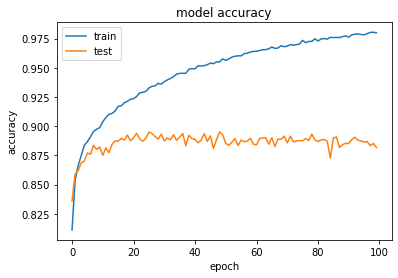

In [5]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

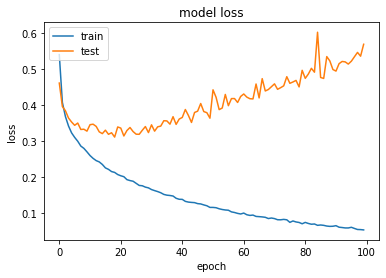

In [6]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
